In [83]:
import pandas as pd
import pymongo
import datetime
import time
import yfinance as yf
import os
from matplotlib import pyplot as plt

import csv
import requests

In [84]:
date = datetime.datetime.now()
d = datetime.timedelta(days = 365)
start_date = date - d
date = date.strftime("%Y-%m-%d")
start_date = start_date.strftime("%Y-%m-%d")
print(date)
print(start_date)

2022-12-31
2021-12-31


In [131]:
def Plot(stock_no = '2330', start_date = start_date, saving = False):
    # dataframe
    stock_no += '.TW' 
    df = yf.download(stock_no, start = start_date)
    df = df.reset_index()
    print(df)
    
    # plot
    ax = plt.gca()
    df.plot(kind='line',x='Date',y='High',ax=ax)
    df.plot(kind='line',x='Date',y='Low', color='red', ax=ax)
    plt.title(stock_no)
    if saving == True:
        save_dir = './plot/'+date+'/'
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        plt.savefig('plot/'+date+'/'+stock_no+'.png')
    plt.show()


In [126]:
CSV_URL = 'https://mopsfin.twse.com.tw/opendata/t187ap03_L.csv'

def Download_csv(url = CSV_URL):
    with requests.Session() as s:
        download = s.get(url)
        decoded_content = download.content.decode('utf-8')
        cr = csv.reader(decoded_content.splitlines(), delimiter=',')
        my_list = list(cr)
        df = pd.DataFrame(my_list)
        new_header = df.iloc[0]
        df = df[1:]
        df.columns = new_header
        return df


In [124]:
# mongo DB
def Convert2dict(data):
    data.reset_index(inplace=True)
    Data_dictionary = data.to_dict('records') # 'dataframe'
    return Data_dictionary

def Link2db(url, db_n, collection_n):
    client = pymongo.MongoClient(url)  
    db = client[db_n]
    collection = db[collection_n]
    dblist = client.list_database_names()
    print(dblist)
    return collection

def Readdb(collection, col = '', reverse = False): # False = big to small
    data_db = collection.find()
    df = pd.DataFrame(list(data_db))
    if col != '':     
        df = df.sort_values(by=[col], ascending=reverse)
    return df
    
def Insert(collection, data, check=True): # Insert data
    df = Readdb(collection)
    start = time.time()
    if df.empty:
        data = Convert2dict(data)
        collection.insert_many(data)
        print('Insert to database')
    elif check:
        if date not in df['Date'].iloc[-1]:
            data = Convert2dict(data)
            collection.insert_many(data)
            print('Insert to database')
    end = time.time()
    df = Readdb(collection)
    print(df)
    print(end-start,'seconds')

def Update(collection):
    myquery = { "Number": { "$regex": "^0" } }
    newvalues = { "$set": { "new": "NNN" } }
    start = time.time()
    x = collection.update_many(myquery, newvalues, upsert = True)
    end = time.time()
    print(x.modified_count, "update")
    print(end-start,'seconds')
    
def Delete(collection):
    myquery = { "Number": { "$regex": "^0" } }
    start = time.time()
    x = collection.delete_many(myquery)
    end = time.time()
    print(end-start,'seconds')


In [117]:
dic = {'公司代號':'Number', '股票代號':'Number', '證券代號':'Number', '股票名稱':'Name', '證券名稱':'Name', '收盤價':'Price', '月平均價':'Price_month',
      '成交股數':'Quantity', '開盤價':'Start', '最高價':'High', '最低價':'Low', '漲跌價差':'Spread'}
data_price = Download_csv('https://www.twse.com.tw/exchangeReport/STOCK_DAY_AVG_ALL?response=open_data') # https://data.gov.tw/dataset/11548
#data_price = pd.read_csv('STOCK_DAY_AVG_ALL_20221227.csv', encoding = 'UTF-8') 
data_price.rename(columns = dic, inplace = True)
data_price.insert(0,'Date',date)
print(data_price)
collect = Link2db('mongodb://localhost:27017/', 'Test', 'Price')
#Insert(collect, data_price)
#Delete(collect)

0            Date Number      Name   Price Price_month
1      2022-12-31   0050    元大台灣50  110.20      113.20
2      2022-12-31   0051   元大中型100   51.25       52.22
3      2022-12-31   0052      富邦科技   92.50       96.21
4      2022-12-31   0053      元大電子   51.40       54.00
5      2022-12-31   0055  元大MSCI金融   21.50       21.72
...           ...    ...       ...     ...         ...
20743  2022-12-31   9944        新麗   20.45       20.47
20744  2022-12-31   9945       潤泰新   43.25       44.47
20745  2022-12-31   9946      三發地產   12.20       12.25
20746  2022-12-31   9955        佳龍   19.80       20.60
20747  2022-12-31   9958       世紀鋼   88.60       88.10

[20747 rows x 5 columns]
['Test', 'admin', 'config', 'local']


['Test', 'admin', 'config', 'local']
      Number     Quantity  Start   High    Low  Spread
0     00632R  135614292.0   5.85   5.87   5.82   -0.04
1       2610  126421384.0  19.80  20.15  19.25    0.25
2     00637L   98143318.0  15.38  15.83  15.34    0.29
3       2618   90864366.0  29.20  29.80  28.35    0.30
4       1605   50670049.0  46.85  48.20  46.85    1.25
...      ...          ...    ...    ...    ...     ...
1176  020016          NaN    NaN    NaN    NaN    0.00
1177  020018          NaN    NaN    NaN    NaN    0.00
1178  020019          NaN    NaN    NaN    NaN    0.00
1179   2836A          NaN    NaN    NaN    NaN    0.00
1180    8488          NaN    NaN    NaN    NaN    0.00

[1181 rows x 6 columns]
00632R
[*********************100%***********************]  1 of 1 completed
          Date  Open  High   Low  Close  Adj Close     Volume
0   2022-01-03  5.09  5.13  5.07   5.11       5.11   89947719
1   2022-01-04  5.08  5.08  5.04   5.04       5.04  168485920
2   2022-01-05  

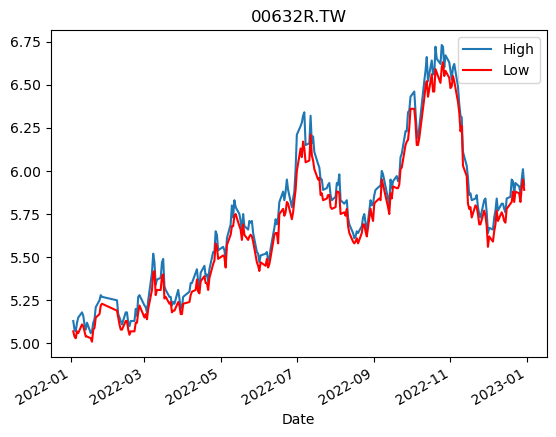

2610
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close  \
0   2022-01-03  27.650000  27.799999  26.100000  26.299999  25.363499   
1   2022-01-04  26.450001  26.700001  26.200001  26.650000  25.701035   
2   2022-01-05  26.500000  27.500000  26.400000  27.299999  26.327890   
3   2022-01-06  27.100000  27.600000  26.799999  27.400000  26.424330   
4   2022-01-07  27.700001  27.900000  25.200001  27.000000  26.038572   
..         ...        ...        ...        ...        ...        ...   
241 2022-12-26  19.100000  19.400000  18.950001  19.100000  19.100000   
242 2022-12-27  19.799999  20.150000  19.250000  19.350000  19.350000   
243 2022-12-28  19.200001  19.450001  19.049999  19.100000  19.100000   
244 2022-12-29  18.900000  19.100000  18.600000  19.000000  19.000000   
245 2022-12-30  19.250000  19.299999  19.000000  19.000000  19.000000   

        Volume  
0    224758909  
1     99097448 

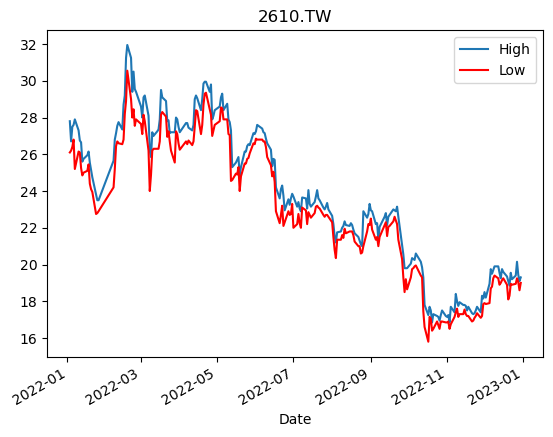

00637L
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close  \
0   2022-01-03  21.940001  22.139999  21.510000  21.670000  21.670000   
1   2022-01-04  21.830000  22.059999  21.100000  21.590000  21.590000   
2   2022-01-05  21.580000  22.030001  21.450001  21.500000  21.500000   
3   2022-01-06  21.430000  21.540001  20.650000  20.930000  20.930000   
4   2022-01-07  20.940001  21.200001  20.830000  21.110001  21.110001   
..         ...        ...        ...        ...        ...        ...   
241 2022-12-26  15.200000  15.290000  15.030000  15.180000  15.180000   
242 2022-12-27  15.380000  15.830000  15.340000  15.470000  15.470000   
243 2022-12-28  15.630000  15.660000  15.240000  15.490000  15.490000   
244 2022-12-29  15.380000  15.380000  15.040000  15.190000  15.190000   
245 2022-12-30  15.420000  15.590000  15.360000  15.470000  15.470000   

       Volume  
0    26223000  
1    65812001  

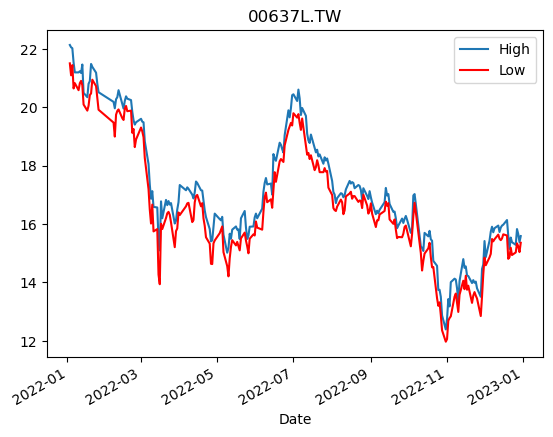

2618
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close  \
0   2022-01-03  28.250000  28.299999  26.600000  26.850000  26.333349   
1   2022-01-04  27.200001  27.250000  26.549999  27.250000  26.725653   
2   2022-01-05  26.950001  27.799999  26.900000  27.299999  26.774691   
3   2022-01-06  27.200001  27.750000  26.900000  27.299999  26.774691   
4   2022-01-07  27.600000  27.950001  25.100000  27.000000  26.480463   
..         ...        ...        ...        ...        ...        ...   
241 2022-12-26  28.200001  28.650000  28.049999  28.150000  28.150000   
242 2022-12-27  29.200001  29.799999  28.350000  28.450001  28.450001   
243 2022-12-28  28.250000  28.600000  28.200001  28.200001  28.200001   
244 2022-12-29  28.000000  28.250000  27.700001  28.150000  28.150000   
245 2022-12-30  28.400000  28.500000  28.150000  28.150000  28.150000   

        Volume  
0    117143905  
1     81994573 

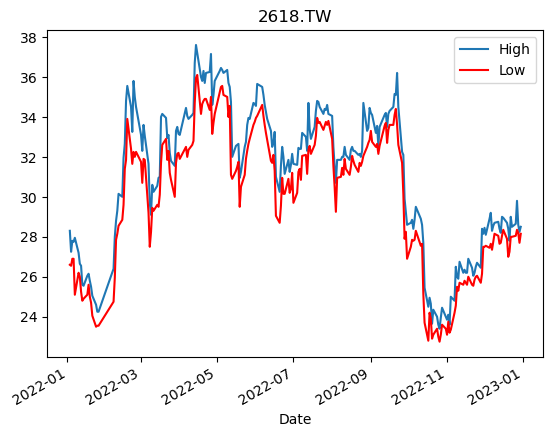

1605
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close  \
0   2022-01-03  26.500000  26.600000  26.200001  26.250000  25.215517   
1   2022-01-04  26.299999  26.350000  26.049999  26.150000  25.119457   
2   2022-01-05  26.049999  26.200001  25.950001  26.049999  25.023397   
3   2022-01-06  26.000000  26.049999  25.799999  25.950001  24.927341   
4   2022-01-07  26.049999  26.049999  25.500000  25.600000  24.591133   
..         ...        ...        ...        ...        ...        ...   
241 2022-12-26  47.099998  47.349998  46.099998  46.650002  46.650002   
242 2022-12-27  46.849998  48.200001  46.849998  47.900002  47.900002   
243 2022-12-28  47.549999  49.000000  47.400002  47.599998  47.599998   
244 2022-12-29  47.599998  47.700001  45.900002  46.599998  46.599998   
245 2022-12-30  47.250000  48.349998  47.000000  47.200001  47.200001   

       Volume  
0     3821670  
1     4519088  
2

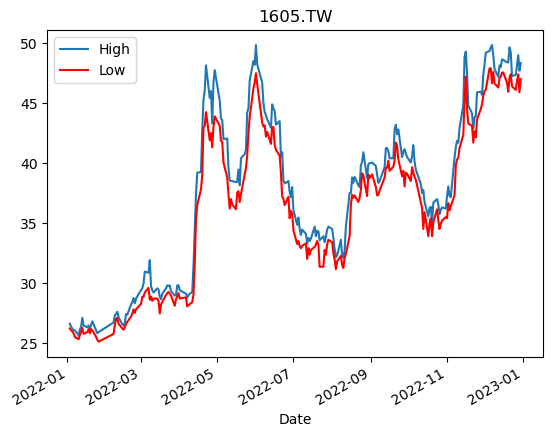

6443
[*********************100%***********************]  1 of 1 completed
          Date       Open       High        Low      Close  Adj Close  \
0   2022-01-03  43.150002  43.250000  41.900002  42.049999  42.049999   
1   2022-01-04  42.349998  43.250000  42.000000  43.049999  43.049999   
2   2022-01-05  43.099998  44.750000  41.849998  42.000000  42.000000   
3   2022-01-06  41.500000  41.700001  40.750000  40.900002  40.900002   
4   2022-01-07  40.549999  41.299999  38.799999  40.250000  40.250000   
..         ...        ...        ...        ...        ...        ...   
241 2022-12-26  34.549999  36.150002  34.549999  35.950001  35.950001   
242 2022-12-27  36.500000  36.900002  35.349998  35.400002  35.400002   
243 2022-12-28  35.299999  35.650002  34.599998  34.799999  34.799999   
244 2022-12-29  34.599998  34.799999  33.599998  34.200001  34.200001   
245 2022-12-30  34.500000  34.599998  34.049999  34.549999  34.549999   

       Volume  
0    19786556  
1    36095785  
2

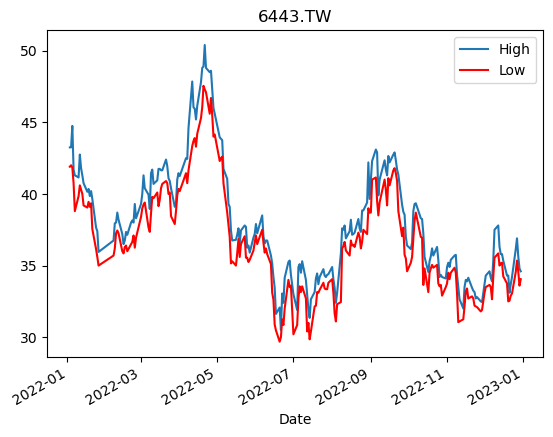

1417
[*********************100%***********************]  1 of 1 completed
          Date   Open   High    Low  Close  Adj Close    Volume
0   2022-01-03  14.75  14.85  14.70  14.75  14.251208    181128
1   2022-01-04  14.85  15.05  14.75  15.00  14.492754    776448
2   2022-01-05  15.10  15.10  14.75  14.80  14.299518    296104
3   2022-01-06  14.75  14.85  14.65  14.65  14.154590    189024
4   2022-01-07  14.80  14.80  14.55  14.70  14.202899    230601
..         ...    ...    ...    ...    ...        ...       ...
241 2022-12-26  14.45  15.40  14.10  15.25  15.250000  25964768
242 2022-12-27  15.35  15.85  14.75  15.05  15.050000  43476434
243 2022-12-28  14.90  15.40  14.65  14.70  14.700000  17701093
244 2022-12-29  14.65  14.75  14.10  14.25  14.250000   5778431
245 2022-12-30  14.45  14.80  14.25  14.25  14.250000   4212756

[246 rows x 7 columns]


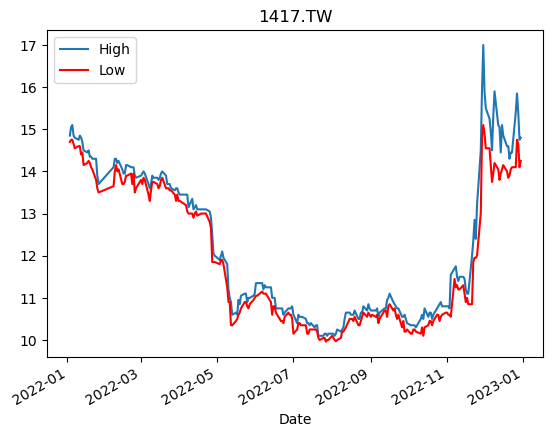

00885
[*********************100%***********************]  1 of 1 completed
          Date       Open   High        Low      Close  Adj Close    Volume
0   2022-01-03  17.700001  17.74  17.700001  17.709999  17.709999   3122807
1   2022-01-04  17.730000  17.90  17.730000  17.870001  17.870001   6338463
2   2022-01-05  17.950001  18.17  17.930000  18.080000  18.080000  13827847
3   2022-01-06  17.980000  18.07  17.900000  18.059999  18.059999   6843148
4   2022-01-07  18.059999  18.08  18.000000  18.010000  18.010000   5315510
..         ...        ...    ...        ...        ...        ...       ...
241 2022-12-26  11.080000  11.23  10.980000  10.990000  10.990000  26066438
242 2022-12-27  10.810000  10.88  10.740000  10.880000  10.880000  37978625
243 2022-12-28  10.910000  11.02  10.870000  10.990000  10.990000  20110119
244 2022-12-29  10.950000  11.10  10.950000  11.030000  11.030000  15949575
245 2022-12-30  11.040000  11.14  11.020000  11.130000  11.130000  17032365

[246 rows x 

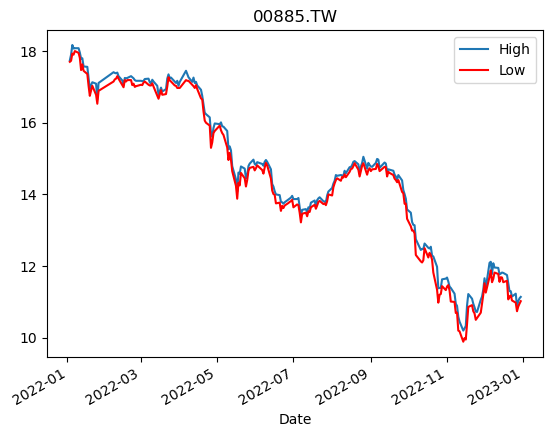

00715L
[*********************100%***********************]  1 of 1 completed
          Date   Open   High    Low  Close  Adj Close    Volume
0   2022-01-03  10.33  10.34  10.18  10.27      10.27  33193560
1   2022-01-04  10.38  10.53  10.38  10.48      10.48  34653166
2   2022-01-05  10.74  10.74  10.60  10.68      10.68  33151500
3   2022-01-06  10.69  10.80  10.59  10.62      10.62  30656162
4   2022-01-07  11.18  11.42  11.18  11.40      11.40  69416187
..         ...    ...    ...    ...    ...        ...       ...
241 2022-12-26  15.31  15.32  15.03  15.12      15.12  17586750
242 2022-12-27  15.49  15.61  15.42  15.54      15.54  31113171
243 2022-12-28  15.40  15.55  15.37  15.41      15.41  17816530
244 2022-12-29  15.08  15.09  14.90  15.01      15.01  19003100
245 2022-12-30  15.01  15.10  14.86  15.05      15.05  12420571

[246 rows x 7 columns]


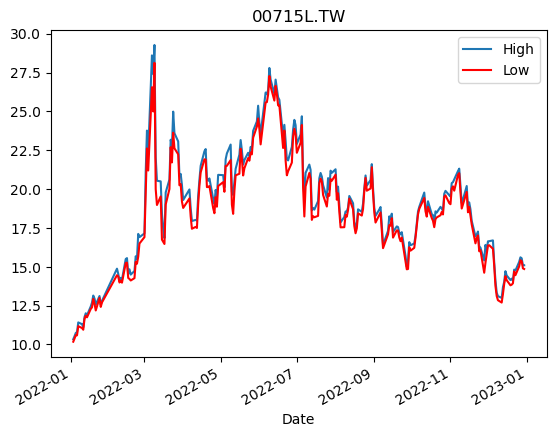

2609
[*********************100%***********************]  1 of 1 completed
          Date        Open        High         Low       Close  Adj Close  \
0   2022-01-03  120.000000  120.500000  113.000000  114.500000  91.203972   
1   2022-01-04  115.000000  116.000000  113.500000  115.500000  92.000511   
2   2022-01-05  115.000000  117.000000  113.500000  115.000000  91.602242   
3   2022-01-06  113.500000  117.000000  113.500000  114.500000  91.203972   
4   2022-01-07  115.500000  116.000000  111.000000  113.500000  90.407425   
..         ...         ...         ...         ...         ...        ...   
241 2022-12-26   67.000000   67.500000   65.000000   65.000000  65.000000   
242 2022-12-27   65.500000   66.199997   65.000000   65.099998  65.099998   
243 2022-12-28   64.800003   65.500000   63.700001   63.900002  63.900002   
244 2022-12-29   63.700001   64.900002   63.599998   64.800003  64.800003   
245 2022-12-30   65.699997   66.199997   65.300003   65.500000  65.500000   

 

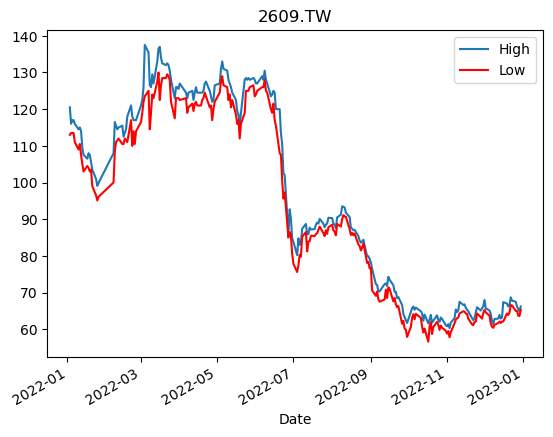

In [134]:
data_quantity = Download_csv('https://www.twse.com.tw/exchangeReport/STOCK_DAY_ALL?response=open_data')  # https://data.gov.tw/dataset/11549
#data_quantity = pd.read_csv('STOCK_DAY_ALL_20221227.csv', encoding = 'UTF-8')
data_quantity.drop(['證券名稱','收盤價','成交金額','成交筆數'], axis=1, inplace = True)
data_quantity.rename(columns = dic, inplace = True)
data_quantity.insert(0,'Date',str(date))
#print(data_quantity)
collect = Link2db('mongodb://localhost:27017/', 'Test', 'Quantity')
#Insert(collect, data_quantity)
df = Readdb(collect,'Quantity')
df.drop(['index'], axis=1, inplace=True)
df = df.groupby(['Number']).mean().sort_values(by=['Quantity'], ascending=False).reset_index()
print(df)
for i in range(10):
    print(df['Number'].iloc[i])
    Plot(df['Number'].iloc[i], saving = True) # saving = True


In [119]:
merge = pd.merge(data_price, data_quantity, on=['Number','Date'], how='inner')
#merge.to_csv('test.csv', index=False, encoding = 'UTF-8')
merge = merge.loc[:,['Date','Number','Price','Price_month','Quantity','Start','High','Low','Spread']]
print(merge)

0           Date Number   Price Price_month Quantity   Start    High     Low  \
0     2022-12-31   0050  110.20      113.20  8890361  110.60  110.75  110.20   
1     2022-12-31   0051   51.25       52.22    12168   51.55   51.55   51.25   
2     2022-12-31   0052   92.50       96.21   112421   93.50   93.60   92.50   
3     2022-12-31   0053   51.40       54.00     7129   52.35   52.40   51.40   
4     2022-12-31   0055   21.50       21.72   239362   21.45   21.58   21.44   
...          ...    ...     ...         ...      ...     ...     ...     ...   
1173  2022-12-31   9944   20.45       20.47    58726   20.45   20.50   20.35   
1174  2022-12-31   9945   43.25       44.47  4756058   43.25   43.50   42.90   
1175  2022-12-31   9946   12.20       12.25    13462   12.20   12.20   12.20   
1176  2022-12-31   9955   19.80       20.60   174902   20.30   20.30   19.80   
1177  2022-12-31   9958   88.60       88.10  4649425   90.90   91.20   88.60   

0      Spread  
0      0.7000  
1      

In [120]:
com = Download_csv('https://mopsfin.twse.com.tw/opendata/t187ap03_L.csv') # https://data.gov.tw/dataset/18419
#com = pd.read_csv('t187ap03_L.csv', encoding = 'UTF-8') 
com.rename(columns = dic, inplace = True)
com['Number'] = com['Number'].apply(str)
com = com.loc[:,['Number','公司名稱','公司簡稱','住址','營利事業統一編號','董事長','過戶電話','過戶地址','傳真機號碼','電子郵件信箱','網址']]
print(com)
collect = Link2db('mongodb://localhost:27017/', 'Test', 'Company')
Insert(collect, com, False)

0   Number              公司名稱  公司簡稱                      住址  營利事業統一編號  董事長  \
1     1101        臺灣水泥股份有限公司    台泥           台北市中山北路2段113號  11913502  張安平   
2     1102        亞洲水泥股份有限公司    亞泥  台北市大安區敦化南路2段207號30、31樓  03244509  徐旭東   
3     1103        嘉新水泥股份有限公司    嘉泥            台北市中山北路2段96號  11892801  張剛綸   
4     1104        環球水泥股份有限公司    環泥        台北市南京東路二段125號10樓  07568009  侯博義   
5     1108        幸福水泥股份有限公司    幸福           台北市松江路237號15樓  40601248  陳兩傳   
..     ...               ...   ...                     ...       ...  ...   
977   9944        新麗企業股份有限公司    新麗            桃園市八德區聯華街41號  33375909  簡瑞瑞   
978   9945      潤泰創新國際股份有限公司   潤泰新       台北市八德路二段三０八號十一樓之一  12139612  簡滄圳   
979   9946  三發地產股份有限公司(原:金革)  三發地產       台北市松山區八德路3段30號12樓  84466749  鍾鼎晟   
980   9955      佳龍科技工程股份有限公司    佳龍      桃園市觀音區大潭里一鄰環科路323號  97211972  吳界欣   
981   9958      世紀鋼鐵結構股份有限公司   世紀鋼        桃園市觀音區中山路一段1119號  22649001  賴文祥   

0             過戶電話                   過戶地址          傳真機號碼  \
1         66365

In [121]:
data = pd.merge(merge, com, on="Number", how='inner')
print(data)
data.to_csv('data.csv', index=False, encoding = 'UTF-8')
collect = Link2db('mongodb://localhost:27017/', 'Test', 'demo')
#Insert(collect, data)

0          Date Number  Price Price_month Quantity  Start   High    Low  \
0    2022-12-31   1101  33.65       33.85  8560973  33.90  34.00  33.65   
1    2022-12-31   1102  41.00       41.16  2299567  40.90  41.10  40.70   
2    2022-12-31   1103  17.40       17.68    54327  17.50  17.50  17.40   
3    2022-12-31   1104  22.20       22.38   180592  22.25  22.25  22.00   
4    2022-12-31   1108  10.75       10.85    33013  10.80  10.80  10.75   
..          ...    ...    ...         ...      ...    ...    ...    ...   
973  2022-12-31   9944  20.45       20.47    58726  20.45  20.50  20.35   
974  2022-12-31   9945  43.25       44.47  4756058  43.25  43.50  42.90   
975  2022-12-31   9946  12.20       12.25    13462  12.20  12.20  12.20   
976  2022-12-31   9955  19.80       20.60   174902  20.30  20.30  19.80   
977  2022-12-31   9958  88.60       88.10  4649425  90.90  91.20  88.60   

0     Spread              公司名稱  公司簡稱                      住址  營利事業統一編號  董事長  \
0    -0.0500        